In [1]:
import numpy as np
import pandas as pd
from numba import jit
from scipy.sparse.linalg import norm
import matplotlib.pyplot as plt

In [2]:
def e(i, d):
    ei = np.zeros(d)
    ei[i] = 1
    return ei



def KWSA(F, w, m, c, d):
    """ 
    Kiefer-Wolfowitz stochastic approximation
    for gradient estimation 
    
    INPUT:
    - F: objective function
    - w: current weight
    - m: sample size (null in this case)
    - d: dimension
    - c: costant
    
    """

    F_wc = np.array([F(w + c * e(i, d)) for i in range(d)])
    return (F_wc - F(w)) / c


@jit(nopython=True, parallel=True)
def IRDSA_out(F, w, m, c, z):
    """ 
    Improvised Random Direction stochastic approximation
    for gradient estimation - output function
    
    INPUT:
    - F: objective function
    - w: current weight
    - m: sample dimension
    - c: costant
    - z: random generated vectors
    
    """
    F_w = F(w)
    out = np.zeros(z.shape[0])
    for i in range(m):
        out += (F(w + c * z[:,i]) - F_w) / c * z[:,i]
    return out/m

def IRDSA(F, w, m, c, d):
    """ 
    Improvised Random Direction stochastic approximation
    for gradient estimation 
    
    INPUT:
    - F: objective function
    - w: current weight
    - m: sample dimension
    - d: features dimension
    - c: costant
    
    """
    z = np.random.normal(0, 1, (d, m))
    return IRDSA_out(F, w, m, c, z)
    
    


def detZFW(F, L, d, w0, r=1, T=100, eps=1e-5):
    """
    INPUT
    - F: loss function
    - L: Lip constant
    - d: dimension
    - w0: starting point
    - r: radius of the ball
    - T: max iteration
    - eps: tolerance
    """

    gamma = lambda t: 2/(t+2)
    c = lambda t: L*gamma(t)/d
    w = w0
    partial = 0
    for t in range(1, T+1):
        # comupute the gradient approx
        gt = KWSA(F, w, None, c(t), d)
        # compute the linear problem solution on the L1 Ball of radius r
        i_k = np.argmax(np.abs(gt))
        ei = e(i_k, d) * r
        v = np.sign(-gt[i_k]) * ei
        # compute step 
        w_pred = w
        w = (1 - gamma(t)) * w + gamma(t) * v
        partial += w
        loss_eval = F(w_pred) - F(w)
        print(f"Loss evaluation at time {t}:\t{loss_eval:.4f}\n")
        if loss_eval < eps: break # check stopping condition
    return F(w_pred), F(w), w, partial/T, t

In [3]:
def stochasticZFW(F, d,  w0, method = "IRDSA", r=1, T=100, eps=1e-5):
    """
    INPUT
    - F: loss function
    - d: dimension
    - w0: starting point
    - method: zeroth order oracle
    - r: radius of the ball
    - T: max iteration
    - eps: tolerance
    """
    
    Parameters_dict = {"KWSA": {"m": None, 
                                "c": lambda t: 2 / (np.sqrt(d) * np.power(t+8, 1/3)),
                                "p": lambda t: 4 / np.power(t+8, 2/3),
                                "oracle": KWSA},
                       
                   
                       "RDSA": {"m": 1, 
                                "c": lambda t: 2 / (np.power(d, 3/2) * np.power(t+8, 1/3)),
                                "p": lambda t: 4 / (np.power(d, 1/3) * np.power(t+8, 2/3)),
                                "oracle": IRDSA},
                   
                       "IRDSA": {"m": 20, 
                                "c": lambda t: 2 * np.sqrt(6) / (np.power(d, 3/2) * np.power(t+8, 1/3)),
                                "p": lambda t: 4 / (np.power(1+d/6, 1/3) * np.power(t+8, 2/3)),
                                "oracle": IRDSA}
                  
                        }
    
    return sZFW(F, d, w0, Parameters_dict[method], r, T, eps)
    
  

    
def sZFW(F, d, w0, params, r, T, eps):
    """
    INPUT
    - F: loss function
    - d: dimension
    - w0: starting point
    - params: dict of parameters for the selected method
    - r: radius of the ball
    - T: max iteration
    - eps: tolerance
    """
    
    loss = []
    gamma = lambda t: 2/(t+8)
    w = w0
    dt = np.zeros(d)
    partial = 0
    for t in range(1, T+1):
        # comupute the gradient approx
        gt = params["oracle"](F, w, params["m"], params["c"](t), d)
        dt = (1 - params["p"](t)) * dt + params["p"](t) * gt
        # compute the linear problem solution on the L1 Ball of radius r
        ei = e(np.argmax(np.abs(dt)), d) * r
        v = np.sign(-dt) * ei
        # compute step 
        w_pred = w
        w = (1 - gamma(t)) * w + gamma(t) * v
        partial += w
        loss_eval = np.abs(F(w_pred) - F(w))
        loss.append(loss_eval)
        print(f"Loss evaluation at time {t}:\t{loss_eval:.4f}\n")
        if loss_eval < eps: break # check stopping condition
    return F(w_pred), F(w), w, partial/T, t, loss


In [4]:
def InexactUpdate(g, d, v, r, gamma, mu):
    """
    INPUT
    - g: gradient approximation 
    - d: dimension
    - v: starting point
    - r: radius
    - gamma: decreasing coefficient
    - mu: threshold
    """
    
    haty = v
    t = 1
    while True:
        # ARGMIN PROBLEM
        ht1 = g + gamma*(haty - v)
        i_k = np.argmax(np.abs(ht1))
        ei = e(i_k, d) * r
        yt = np.sign(-ht1[i_k]) * ei
        if np.dot(ht1, yt - haty) >= - mu:
            break
        else:
            haty = (t-1)/(t+1) * haty + 2/(t+1)*yt
            t +=1
    return haty
    

def IZFW(F, d, w0, L, B = 1, r = 1, T = 100, eps = 1e-6):
    """
    INPUT
    - F: loss function
    - d: dimension
    - w0: starting point
    - L: lipschitz
    - B: 1
    - r: radius of the ball
    - T: max iteration
    - eps: tolerance
    """
    
    alpha = lambda t: 2/(t+2)
    gamma = lambda t: 4*L/t
    mu = lambda t: L*2*r/(t*T)
    m = lambda t: 100 #t * (t+1) / 2*r * np.max([(d+5)*B*T, d+3])
    c = 1 / (np.sqrt(2*T)) * np.max([1/(d+3), np.sqrt(2*r/(d*(T+1)))]) # smoothing parameter now fixed
    
    loss = []
    v, w = w0, w0
    partial = 0
    
    for t in range(1, T+1):
        dt = (1-alpha(t)) * w + alpha(t) * v
        g = IRDSA(F, dt, int(np.ceil(m(t))), c, d)
        v = InexactUpdate(g, d, v, r, gamma(t), mu(t)) #ICG
        w_pred = w
        w = (1 - alpha(t)) * w + alpha(t) * v
        partial += w
        loss_eval = np.abs(F(w_pred) - F(w))
        loss.append(loss_eval)
        print(f"Loss evaluation at time {t}:\t{loss_eval:.4f}\n")
        if loss_eval < eps: break # check stopping condition
    return F(w_pred), F(w), w, partial/T, t, loss

In [5]:
clinical = pd.read_table('../Data/SurvivalTimes.txt', index_col=0, sep=';')
clinical = clinical.set_index(clinical["IDs"], drop=True).iloc[:,:-1]
clinical["death_event"].value_counts()

0    375
1    162
Name: death_event, dtype: int64

In [6]:
data = pd.read_table("../Data/mydata.txt", sep = ";")
data = data.T

In [7]:
df = data.merge(clinical, left_index= True, right_index = True)
df = df.sort_values(by = "new_death")
df.head()

,?|10431,?|553137,?|57714,?|653553,?|8225,A2M|2,A4GALT|53947,AAAS|8086,AACS|65985,AAGAB|79719,...,ZSWIM7|125150,ZW10|9183,ZXDB|158586,ZXDC|79364,ZYG11B|79699,ZYX|7791,ZZEF1|23140,ZZZ3|26009,new_death,death_event
TCGA-A3-A8OX,864.8329,123.6901,762.7553,259.3501,527.3452,32553.2802,972.8954,525.3502,734.8253,741.1428,...,470.8900,328.5101,289.2751,967.5754,990.5179,4045.8617,1415.1206,592.1828,0,0
TCGA-A3-A8OU,642.0154,431.5319,624.5429,399.0248,788.7038,31333.4945,1786.6721,702.1536,526.2089,503.0475,...,419.2483,250.7111,383.1776,1112.9622,899.2280,4225.9244,1418.1227,449.8171,0,0
TCGA-BP-4337,934.0463,772.7273,466.1319,596.2567,699.6435,32191.5642,2510.2496,938.0570,881.4617,651.9608,...,267.3975,228.6096,189.8396,1154.1889,616.7558,5067.7362,1319.0731,471.0339,2,1
TCGA-A3-A8CQ,477.9031,283.6534,722.9503,337.7019,779.4372,31045.7665,1935.5887,615.6660,712.7908,408.4121,...,250.2895,289.7491,376.3080,1091.9435,967.9976,3791.5270,1752.7177,611.6022,3,0
TCGA-A3-A6NN,310.8729,556.6616,915.3905,234.3032,463.6294,40603.1432,2385.1455,638.2083,343.4150,494.6401,...,282.2358,351.8377,465.1608,907.7335,1130.1685,2765.3139,2091.5008,774.1194,3,0


In [8]:
X, y, time = df.iloc[:,:-2], df.iloc[:,-1].values, df.iloc[:,-2].values
X = np.array(X.apply(lambda x: (x - np.mean(x))/np.std(x), axis = 0))
print(f"X shape: {X.shape}\ny shape: {y.shape}\ntime shape: {time.shape}")

X shape: (533, 9375)
y shape: (533,)
time shape: (533,)


In [9]:
n, d = X.shape

In [10]:
# define the objective function
@jit(nopython=True)
def F(w):
    output = 0
    for i in range(n):
        if y[i] == 1:
            sum_jR = np.sum(np.exp((X @ w)[i:]))
            output += y[i]*(-X[i,:] @ w + np.log(sum_jR)) 
    return 1/n * output

# sum_jR = 0
#for j in range(n):
#    if time[j] >= time[i]:
#        sum_jR += np.exp(X.iloc[j,:].values @ w)     
#       

In [11]:
# initialize prarameters for the algorithm
# stating point 
np.random.seed(7)
w0 = np.random.rand(d)
w0 = w0/np.sum(w0) * np.random.rand(1) *10
#print(w0)
#print(F(w0))

# Lipschitz constant computation
L = 2/X.shape[0] * np.linalg.norm(X.T @ X)
print(f"L: {L}")

L: 4213.199932480764


In [12]:
np.linalg.norm(w0, 1)

8.899985191618605

In [13]:
%%time
fpred, f, w, mean, t, loss = stochasticZFW(F, d, w0, method = "IRDSA", r=10, T=40, eps=1e-3)

Loss evaluation at time 1:	0.8011

Loss evaluation at time 2:	1.6963

Loss evaluation at time 3:	0.6538

Loss evaluation at time 4:	0.3548

Loss evaluation at time 5:	1.1387

Loss evaluation at time 6:	0.7195

Loss evaluation at time 7:	0.2751

Loss evaluation at time 8:	0.1133

Loss evaluation at time 9:	0.4795

Loss evaluation at time 10:	0.6669

Loss evaluation at time 11:	0.6685

Loss evaluation at time 12:	0.7922

Loss evaluation at time 13:	0.2665

Loss evaluation at time 14:	0.2230

Loss evaluation at time 15:	0.2760

Loss evaluation at time 16:	0.2087

Loss evaluation at time 17:	0.4943

Loss evaluation at time 18:	0.1245

Loss evaluation at time 19:	0.0477

Loss evaluation at time 20:	0.4053

Loss evaluation at time 21:	0.2718

Loss evaluation at time 22:	0.1121

Loss evaluation at time 23:	0.6270

Loss evaluation at time 24:	0.2114

Loss evaluation at time 25:	0.0334

Loss evaluation at time 26:	0.0169

Loss evaluation at time 27:	0.2172

Loss evaluation at time 28:	0.1106

L

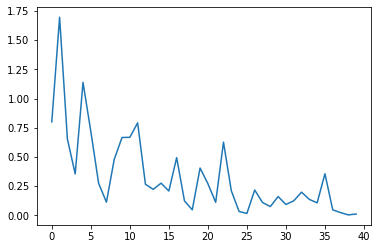

In [14]:
plt.plot(loss)

In [15]:
print(F(w0), F(w))

2.1905202447317853 2.677820278110253


In [16]:
print(f'OUTPUT:\n\nF(w_pred) = {fpred}\n\nF(w) = {f}\n\nw = {w}\n\naverage w = {mean}\n\nT = {t}')

OUTPUT:

F(w_pred) = 2.665860761476593

F(w) = 2.677820278110253

w = [3.61582976e-06 3.69560582e-05 2.07738001e-05 ... 1.27056747e-05
 5.13115687e-07 2.43617941e-05]

average w = [2.12429999e-05 2.17116842e-04 1.22046075e-04 ... 7.46458388e-05
 3.01455466e-06 1.43125540e-04]

T = 40


In [17]:
%%time
fpred, f, w, mean, t, loss = stochasticZFW(F, d, w0, method = "RDSA", r=10, T=40, eps=1e-3)

Loss evaluation at time 1:	0.0868

Loss evaluation at time 2:	0.7124

Loss evaluation at time 3:	0.5661

Loss evaluation at time 4:	0.5851

Loss evaluation at time 5:	0.2381

Loss evaluation at time 6:	0.2355

Loss evaluation at time 7:	1.6984

Loss evaluation at time 8:	1.5081

Loss evaluation at time 9:	1.2557

Loss evaluation at time 10:	0.6220

Loss evaluation at time 11:	0.5072

Loss evaluation at time 12:	1.0941

Loss evaluation at time 13:	0.9278

Loss evaluation at time 14:	0.9102

Loss evaluation at time 15:	0.5459

Loss evaluation at time 16:	0.2389

Loss evaluation at time 17:	0.1454

Loss evaluation at time 18:	0.0654

Loss evaluation at time 19:	0.1790

Loss evaluation at time 20:	0.0805

Loss evaluation at time 21:	0.3382

Loss evaluation at time 22:	0.0770

Loss evaluation at time 23:	0.0203

Loss evaluation at time 24:	0.0309

Loss evaluation at time 25:	0.0359

Loss evaluation at time 26:	0.0391

Loss evaluation at time 27:	0.0410

Loss evaluation at time 28:	0.0421

L

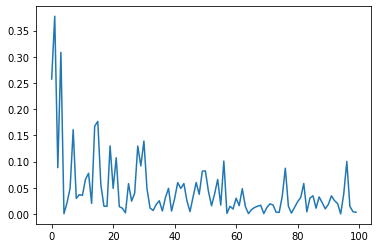

In [4]:
import numpy as np
import matplotlib.pyplot as plt

loss_cox = np.load('../Data/results/loss_SZFW_IRDSA_cox.npy')
plt.plot(loss_cox)
plt.show()

In [5]:
loss_cox

array([2.57475271e-01, 3.77257838e-01, 8.83232584e-02, 3.08421113e-01,
       5.27266767e-04, 2.14881895e-02, 4.92702923e-02, 1.60761101e-01,
       2.97962639e-02, 3.67848683e-02, 3.55033193e-02, 6.61694092e-02,
       7.76986744e-02, 2.02368064e-02, 1.67542104e-01, 1.76617601e-01,
       5.55514267e-02, 1.49123881e-02, 1.44853056e-02, 1.29894924e-01,
       4.88857138e-02, 1.07226293e-01, 1.40213358e-02, 1.09732353e-02,
       2.12429754e-03, 5.78657980e-02, 2.44474355e-02, 3.99791215e-02,
       1.29664660e-01, 9.17045578e-02, 1.39133040e-01, 4.83548157e-02,
       1.14178391e-02, 6.64772664e-03, 1.78797736e-02, 2.52544060e-02,
       5.69452217e-03, 3.11222120e-02, 4.89797343e-02, 5.58472737e-03,
       2.95214404e-02, 5.98512601e-02, 4.87963979e-02, 5.80204119e-02,
       2.49550240e-02, 4.51747836e-03, 3.26727585e-02, 6.00295119e-02,
       3.75754256e-02, 8.16831423e-02, 8.21276038e-02, 4.29698503e-02,
       1.56283743e-02, 3.82045426e-02, 6.59104139e-02, 1.69776081e-02,
      